In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor)
import sys
import os

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *

/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

n_rct_before_split = 10**5
n_host = 200
sigma_prior = 1
sigma_rand_error = 1
include_intercept = 1  # 0 if no intercept
power_x, power_x_t = 1, 1

X0 = np.random.beta(12, 3, size=n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions = {"X_0": X0, "X_1": X1, "X_2": X2}
d = (
    include_intercept
    + len(x_distributions) * (power_x)
    + 1
    + len(x_distributions) * (power_x_t)
)

p_assigned_to_host = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)
p_assigned_to_cand2 = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)


causal_param_first_index = power_x*len(x_distributions) + include_intercept 

outcome_function = (
    # y = 1 + 1*X_0 - 1*X_1 + 1*X_2 + 4*T + 2*X_0*T + 2*X_1*T + 0*X_2*T + eps
    lambda X, T, eps: include_intercept  # intercept, non-causal => 0 no intercept
    + 1 * X["X_0"]  # non-causal
    - 1 * X["X_1"]  # non-causal
    + 1 * X["X_2"]  # non-causal
    + 4 * T  # causal
    + 2 * X["X_0"] * T  # causal
    + 2 * X["X_1"] * T  # causal
    + 0 * X["X_2"] * T  # causal
    + eps
)
if include_intercept:
    true_params = np.array([1, 1, -1, 1, 4, 2, 2, 0])  # intercept, non-causal => 0
else:
    true_params = np.array([1, -1, 1, 4, 2, 2, 0])  # copied from above
std_true_y = 1  # Standard deviation for the true Y

Simulation parameters

In [3]:
# Prior parameters for Bayesian update on host
if include_intercept:
    prior_mean = np.array([0, 1, 0, 0, 1, 0, 0, 0])
else:
    prior_mean = np.array([1, 0, 0, 1, 0, 0, 0])
assert len(prior_mean) == d, "Shape error"

beta_0, sigma_0_sq, inv_cov_0 = (
    prior_mean,
    sigma_rand_error**2,
    1 / sigma_prior * np.eye(len(prior_mean)),
)
prior_hyperparameters = {
    "beta_0": beta_0,
    "sigma_0_sq": sigma_0_sq,
    "inv_cov_0": inv_cov_0,
}


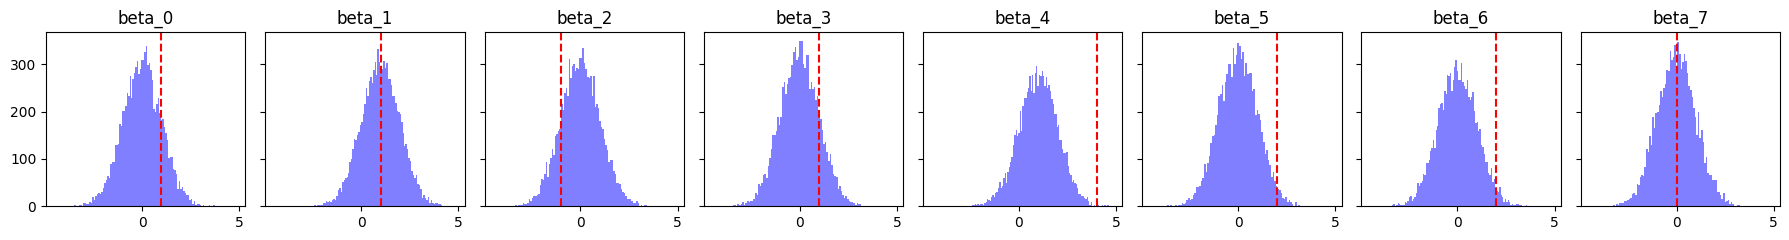

In [4]:
# only meaningful if the outcome model is linear 

# sample from the prior:
beta_samples = rng.multivariate_normal(
    prior_mean, cov=sigma_prior * np.eye(len(prior_mean)), size=10000
)
# plot the prior samples and true_params as red crosses:
# let's do d subplots
ax, fig = plt.subplots(1, d, figsize=(18, 2.5), sharex=True, sharey=True)

# on each subplot, plot the prior samples and the true params
for i in range(d):
    fig[i].hist(beta_samples[:, i], bins=100, alpha=0.5, color="blue")
    fig[i].axvline(true_params[i], color="red", linestyle="--")
    fig[i].set_title(f"beta_{i}")

plt.tight_layout()
plt.show()

In [5]:
n_both_candidates_list = [200, 500, 1000]
proportion = 1  # n_cand2 = prorportion * n_both_candidates_list
std_true_y = 1


data_parameters = {
    "n_both_candidates_list": n_both_candidates_list,
    "proportion": proportion,
    "n_rct_before_split": n_rct_before_split,
    "x_distributions": x_distributions,
    "p_assigned_to_cand2": p_assigned_to_cand2,
    "p_assigned_to_host": p_assigned_to_host,
    "n_host": n_host,
    "power_x": power_x,
    "power_x_t": power_x_t,
    "outcome_function": outcome_function,
    "std_true_y": std_true_y,
    "causal_param_first_index": causal_param_first_index,
}

### 2. EIG closed form 

In [6]:
n_seeds = 10

text_l1 = "p_assigned_to_host=p_assigned_to_cand2, n_samples_for_expectation = 30,"
text_l2 = "m_samples_for_expectation = 500, n_host = 200, sigma_prior = 1, sigma_rand_error = 1,"
text_l3 = "outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 1 * T + 2* X[:,0]*T + 2* X[:,1]*T +2* X[:,2]*T + eps"

In [7]:
np.random.seed(0)
length_specific_seeds_exact = np.random.randint(0, 1000 + 1, size=len(data_parameters["n_both_candidates_list"]))
exact_data = generate_exact_data_varying_sample_size(
    data_parameters, include_intercept=bool(include_intercept),
    length_specific_seeds= length_specific_seeds_exact
)
exact_data[200]["host"]

,intercept,X_0,X_1,X_2,T,T*X_0,T*X_1,T*X_2,Y
0,1.0,0.860735,4.433205,0.014354,0.0,0.000000,0.000000,0.000000,-2.879495
1,1.0,0.887912,2.697616,0.182670,1.0,0.887912,2.697616,0.182670,12.304491
2,1.0,0.919261,4.995789,0.129797,1.0,0.919261,4.995789,0.129797,12.944813
3,1.0,0.928079,4.081898,0.083770,1.0,0.928079,4.081898,0.083770,12.146424
4,1.0,0.682986,5.654190,0.009985,1.0,0.682986,5.654190,0.009985,12.560376
...,...,...,...,...,...,...,...,...,...
195,1.0,0.876544,4.501108,0.156287,1.0,0.876544,4.501108,0.156287,10.493048
196,1.0,0.809963,2.612383,0.193905,1.0,0.809963,2.612383,0.193905,10.387760
197,1.0,0.881355,2.826880,0.030432,1.0,0.881355,2.826880,0.030432,9.199344
198,1.0,0.931871,3.048808,0.142466,0.0,0.000000,0.000000,0.000000,-1.927564


In [8]:
dict_additional_plots_obs_closed_from, dict_additional_plots_caus_closed_from = (
    linear_eig_closed_form_varying_sample_size(
        exact_data,
        data_parameters,
        prior_hyperparameters,
    )
)

For a sample size of 200
 % treated in host: 67%
 % treated in exact_twin_untreated: 0%
 % treated in exact_complementary: 33%
 % treated in exact_twin: 67%
 % treated in exact_twin_treated: 100%
For a sample size of 500
 % treated in host: 67%
 % treated in exact_twin_untreated: 0%
 % treated in exact_complementary: 36%
 % treated in exact_twin: 63%
 % treated in exact_twin_treated: 100%
For a sample size of 1000
 % treated in host: 79%
 % treated in exact_twin_untreated: 0%
 % treated in exact_complementary: 23%
 % treated in exact_twin: 77%
 % treated in exact_twin_treated: 100%


In [9]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []

for i in range(n_seeds):
    np.random.seed(i)
    length_specific_seeds = np.random.randint(0, 1000 + 1, size=len(data_parameters["n_both_candidates_list"]))
    nonexact_data = generate_data_varying_sample_size(
        data_parameters, include_intercept=bool(include_intercept), length_specific_seeds=length_specific_seeds
    )
    EIGs = linear_eig_closed_form_varying_sample_size(  # CHECK what this does
        nonexact_data,
        data_parameters,
        prior_hyperparameters,
        verbose=False,
    )
    EIG_obs_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )


EIG_obs_closed_form_across_seeds = np.vstack(EIG_obs_closed_form_across_seeds)  
EIG_caus_closed_form_across_seeds = np.vstack(EIG_caus_closed_form_across_seeds)


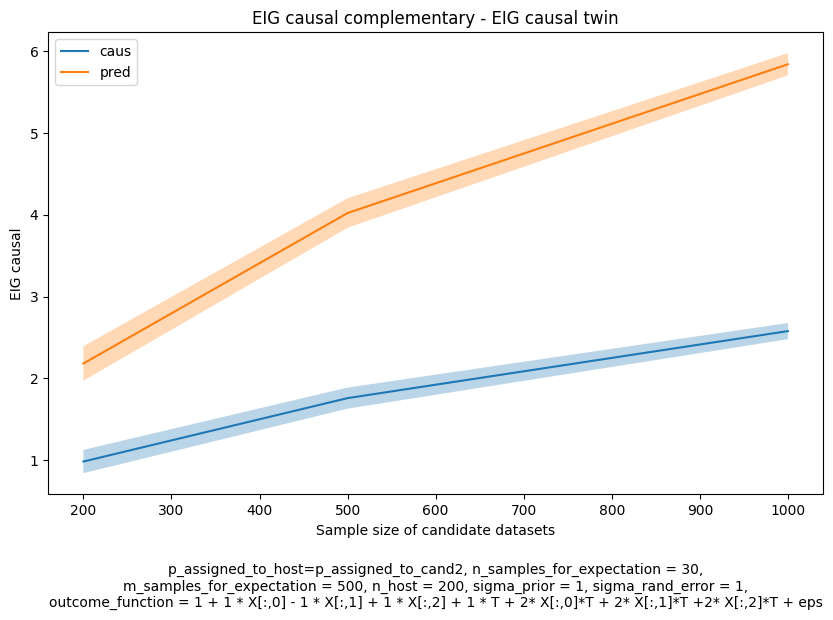

In [18]:
# # path_obs_closed_form = '/Users/lucile/causal_info_gain/plots/eig_obs_closed_form'
# path_obs_closed_form = ""

# plot_array(
#     x=n_both_candidates_list,  # sample sizes
#     arr_list=[EIG_obs_closed_form_across_seeds],
#     label_names = ["complementary - twin"],
#     axis_names=["Sample size of candidate datasets", "EIG predictive"],
#     dict_additional_plots=dict_additional_plots_obs_closed_from,
#     text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
#     title="EIG predictive complementary - EIG predictive twin",
# )

# path_caus_closed_form = '/Users/lucile/causal_info_gain/plots/eig_caus_closed_form'
# path_caus_closed_form = 0

# plot_array(
#     n_both_candidates_list,
#     arr_list=[EIG_caus_closed_form_across_seeds],
#     label_names = ["complementary - twin"],
#     axis_names=["Sample size of candidate datasets", "EIG causal"],
#     dict_additional_plots=dict_additional_plots_caus_closed_from,
#     text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
#     title="EIG causal complementary - EIG causal twin",
# )

# path_closed_form = '/Users/lucile/causal_info_gain/plots/eig_closed_form'

plot_array(
    n_both_candidates_list,
    arr_list=[EIG_caus_closed_form_across_seeds, EIG_obs_closed_form_across_seeds],
    label_names = ["caus", "pred"],
    axis_names=["Sample size of candidate datasets", "EIG causal"],
    dict_additional_plots=None,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
    title="EIG causal complementary - EIG causal twin",
)

### 2. EIG from samples for varying sample sizes

In [26]:
n_samples_outer_expectation_obs = 300
n_samples_inner_expectation_obs = 500
n_samples_outer_expectation_caus = 300
n_samples_inner_expectation_caus = 500

sampling_parameters = {
    "n_samples_inner_expectation_obs": n_samples_inner_expectation_obs,
    "n_samples_outer_expectation_obs": n_samples_outer_expectation_obs,
    "n_samples_inner_expectation_caus": n_samples_inner_expectation_caus,
    "n_samples_outer_expectation_caus": n_samples_outer_expectation_caus,
}

In [27]:
dict_additional_plots_obs_from_samples, dict_additional_plots_caus_from_samples = (
    linear_eig_from_samples_varying_sample_size(
        exact_data,
        data_parameters,
        prior_hyperparameters,
        sampling_parameters
    )
)

In [28]:
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range(n_seeds):
    EIGs = linear_eig_from_samples_varying_sample_size(
        nonexact_data, data_parameters, prior_hyperparameters, sampling_parameters
    )
    EIG_obs_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )

EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)


In [29]:
text_l1 = "p_assigned_to_host=p_assigned_to_cand2, approx 0.8 treated in host"
text_l2 = (
    "n_samples_inner_expectation_obs = "
    + str(n_samples_inner_expectation_obs)
    + "n_samples_outer_expectation_obs = "
    + str(n_samples_outer_expectation_obs)
    + ", n_host = "
    + str(n_host)
    + ", sigma_prior = sigma_rand_error = "
    + str(sigma_rand_error)
)
text_l4 = (
    "n_host = 200, sigma_prior = sigma_rand_error = 1, n_samples_inner_expectation_caus = "
    + str(n_samples_inner_expectation_caus)
)

In [30]:
# path_obs_closed_form = ""

# plot_array(
#     x=n_both_candidates_list,  # sample sizes
#     arr=EIG_obs_samples_across_seeds,
#     axis_names=["Sample size of candidate datasets", "EIG predictive"],
#     dict_additional_plots=dict_additional_plots_obs_closed_from,
#     text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
#     title="EIG predictive complementary - EIG predictive twin",
# )

# # path_obs_samples = '/Users/lucile/causal_info_gain/plots/eig_obs_samples'
# path_caus_samples = 0

# plot_array(
#     x = n_both_candidates_list,
#     arr = EIG_caus_samples_across_seeds,
#     axis_names=["Sample size of candidate datasets", "EIG predictive"],
#     dict_additional_plots=dict_additional_plots_obs_from_samples,
#     text=text_l1 + "\n" + text_l2 + "\n" + text_l3 + "\n" + text_l4,
#     title="EIG predictive complementary - EIG predictive twin"
# )


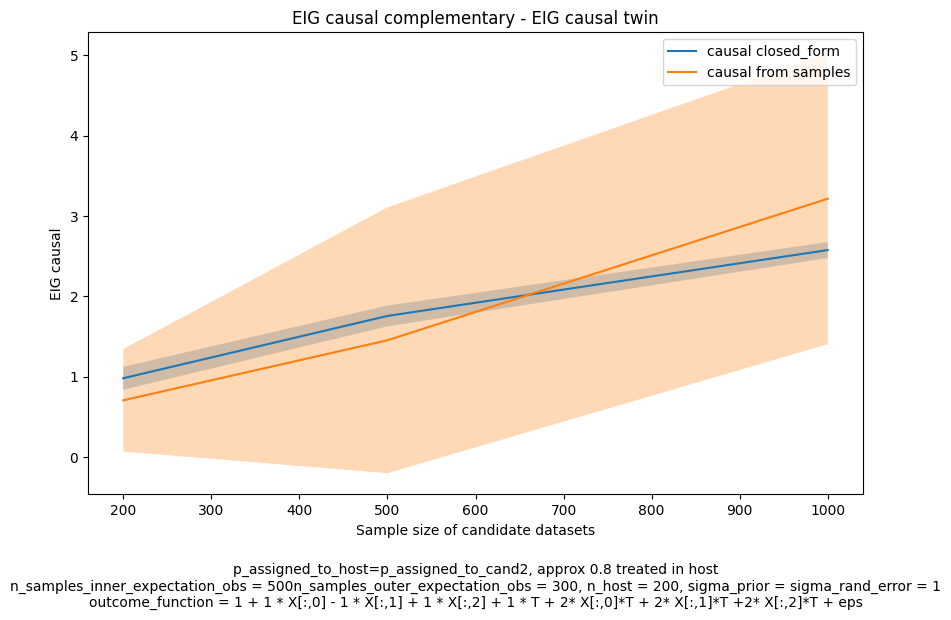

In [31]:
plot_array(
    n_both_candidates_list,
    arr_list=[EIG_caus_closed_form_across_seeds, EIG_caus_samples_across_seeds],
    label_names = ["causal closed_form", "causal from samples"],
    axis_names=["Sample size of candidate datasets", "EIG causal"],
    dict_additional_plots=None,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
    title="EIG causal complementary - EIG causal twin",
)

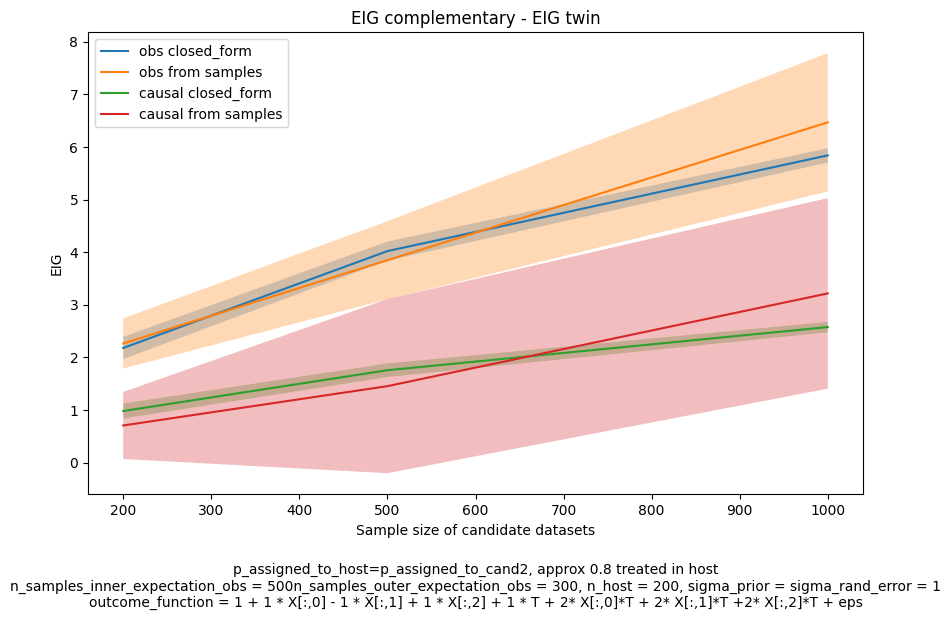

In [32]:
plot_array(
    n_both_candidates_list,
    arr_list=[EIG_obs_closed_form_across_seeds, EIG_obs_samples_across_seeds, EIG_caus_closed_form_across_seeds, EIG_caus_samples_across_seeds],
    label_names = ["obs closed_form", "obs from samples", "causal closed_form", "causal from samples"],
    axis_names=["Sample size of candidate datasets", "EIG"],
    dict_additional_plots=None,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
    title="EIG complementary - EIG twin",
)

In [33]:
merged_datasets = {}

for sample_size, data_dict in nonexact_data.items():
    merged_data_dict = {}
    for name, data in data_dict.items():
        if name != 'host':
            merged_data_dict[name]= pd.concat([data_dict['host'], data_dict[name]], axis=0)
    merged_datasets[sample_size] = merged_data_dict

In [34]:
from sklearn.linear_model import LinearRegression
merged_mse = {}

for sample_size, data_dict in merged_datasets.items():
    model = LinearRegression
    model.fit()

TypeError: fit() missing 3 required positional arguments: 'self', 'X', and 'y'

In [ ]:
np.shape(EIG_caus_closed_form_across_seeds) # 2*n_seeds x number_of_sample_sizes
# alternate between complementary and twin

(20, 3)